# Otto Group Product Classification Challenge

[Classify products into the correct category](https://www.kaggle.com/c/otto-group-product-classification-challenge)

_Y. Sun_

This multi-classification problem is a great example of implementing XGBoost.

In [25]:
# download data
#!kaggle competitions download -c otto-group-product-classification-challenge
#!unzip otto-group-product-classification-challenge.zip

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier, plot_importance

%matplotlib inline

# path of data files in local ubuntu
path_data = '/home/ys/data/otto-group-product-classification-challenge/'

In [2]:
# training data
df_train = pd.read_csv(path_data + 'train.csv')
print(df_train.shape)
df_train.tail(3)

(61878, 95)


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
61875,61876,0,0,0,0,0,0,0,3,1,...,0,3,1,0,0,0,0,0,0,Class_9
61876,61877,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,10,0,Class_9
61877,61878,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,Class_9


In [39]:
# check the default hyperparameeters
XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [16]:
# split data into X and y
X = df_train.drop(['id', 'target'], axis=1)
y = df_train['target']
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)
# seperate validation data
X_train, X_val, y_train, y_val = train_test_split(
    X, label_encoded_y, test_size=0.2, random_state=0) 
# build the model
model = XGBClassifier(n_estimators=100, 
                      learning_rate=0.1,  
                      max_depth=6, 
                      subsample=0.75,
                      colsample_bylevel=0.8,
                      gamma=0,
                      objective='multi:softprob', 
                      n_jobs=-1, nthread=-1)
# train the model
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds=10, 
          eval_metric=['mlogloss'], eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:1.96137	validation_1-mlogloss:1.96673
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.79277	validation_1-mlogloss:1.80313
[2]	validation_0-mlogloss:1.65989	validation_1-mlogloss:1.67357
[3]	validation_0-mlogloss:1.55035	validation_1-mlogloss:1.56689
[4]	validation_0-mlogloss:1.45711	validation_1-mlogloss:1.47678
[5]	validation_0-mlogloss:1.37676	validation_1-mlogloss:1.39863
[6]	validation_0-mlogloss:1.30601	validation_1-mlogloss:1.33017
[7]	validation_0-mlogloss:1.2429	validation_1-mlogloss:1.26938
[8]	validation_0-mlogloss:1.18749	validation_1-mlogloss:1.21607
[9]	validation_0-mlogloss:1.13792	validation_1-mlogloss:1.16816
[10]	validation_0-mlogloss:1.09343	validation_1-mlogloss:1.12542
[11]	validation_0-mlogloss:1.05334	validation_1-mlogloss:1.08692
[12]	validation_0-mlogloss:1.01695	validation_1-mlogloss:1.05213

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.75, verbosity=1)

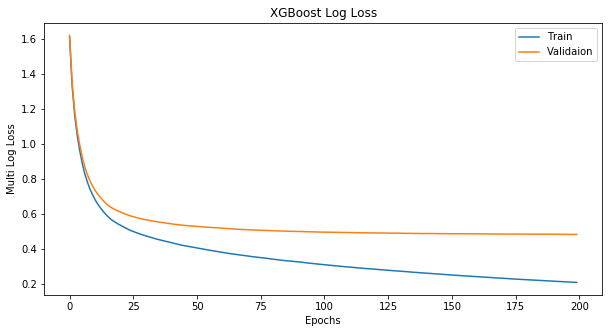

In [53]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validaion')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Multi Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

Accuracy of validation data: 81.83 %
Confusion matrix of validation data:
 [[ 206    8    2    0    0   26   12   56   60]
 [   1 2734  383   36    5    7   24    9    6]
 [   1  666  809   31    0    3   34    2    0]
 [   0  153   84  304    3   15    4    1    2]
 [   1    9    1    1  525    1    0    1    3]
 [  17   19    5    5    0 2671   48   33   25]
 [  12   53   42   11    2   37  388   24    3]
 [  25   15    8    0    2   37   18 1579   19]
 [  40   17    1    2    2   37   10   29  911]]


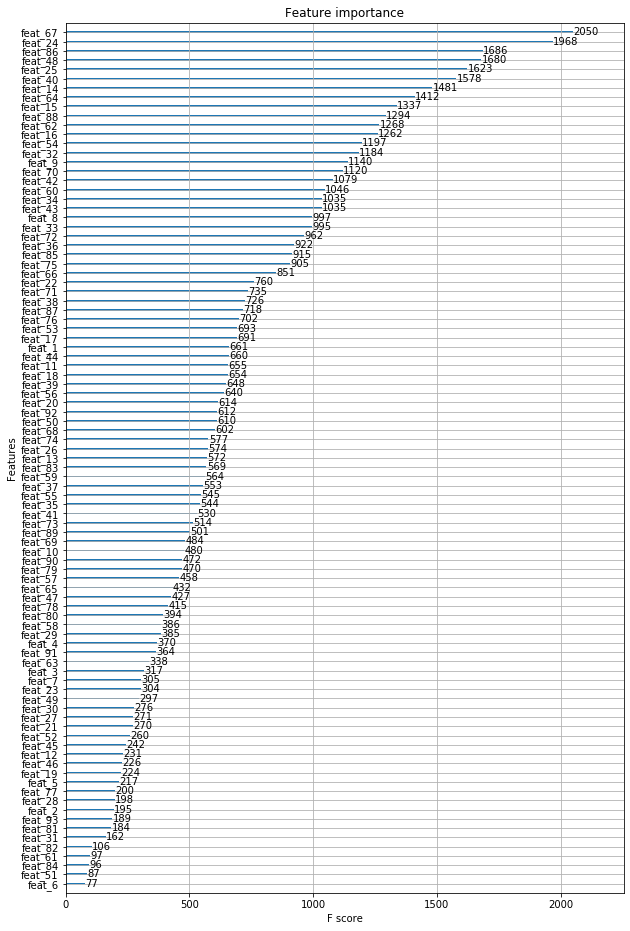

In [54]:
# model perfromance evaluation
y_val_pred = model.predict(X_val)
print('Accuracy of validation data: %.2f %%' % (accuracy_score(y_val, y_val_pred) * 100))
print('Confusion matrix of validation data:\n', confusion_matrix(y_val, y_val_pred))

# plot feature importance
fig, ax = plt.subplots(figsize=(10, 16))
plot_importance(model, ax=ax)
plt.show()

#### Tune n_estimators

In [ ]:
# grid search 
model = XGBClassifier()
n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators.png')

#### Tune max_depth

In [ ]:
# grid search 
model = XGBClassifier()
max_depth = range(1, 11, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.savefig('max_depth.png')

#### Tune n_estimators & max_depth

In [ ]:
# grid search
model = XGBClassifier()
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold,
verbose=1)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label= ' depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth.png')

In [52]:
# retrain the model on all training data with best hyperparameters
model = XGBClassifier(n_estimators=200, 
                      learning_rate=0.3,
                      max_depth=6,                      
                      subsample=0.75,
                      colsample_bylevel=0.3,
                      gamma=0,
                      objective='multi:softprob', 
                      n_jobs=-1, nthread=-1)
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds=10, 
          eval_metric=['mlogloss'], eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:1.61107	validation_1-mlogloss:1.62072
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.33302	validation_1-mlogloss:1.35271
[2]	validation_0-mlogloss:1.16578	validation_1-mlogloss:1.19095
[3]	validation_0-mlogloss:1.04839	validation_1-mlogloss:1.07655
[4]	validation_0-mlogloss:0.960483	validation_1-mlogloss:0.993803
[5]	validation_0-mlogloss:0.886468	validation_1-mlogloss:0.923131
[6]	validation_0-mlogloss:0.827068	validation_1-mlogloss:0.867383
[7]	validation_0-mlogloss:0.781117	validation_1-mlogloss:0.823759
[8]	validation_0-mlogloss:0.741441	validation_1-mlogloss:0.787644
[9]	validation_0-mlogloss:0.709886	validation_1-mlogloss:0.759676
[10]	validation_0-mlogloss:0.680417	validation_1-mlogloss:0.734225
[11]	validation_0-mlogloss:0.656758	validation_1-mlogloss:0.713158
[12]	validation_0-mlogloss:0.635388	validation_

[121]	validation_0-mlogloss:0.281088	validation_1-mlogloss:0.490094
[122]	validation_0-mlogloss:0.279846	validation_1-mlogloss:0.489854
[123]	validation_0-mlogloss:0.278869	validation_1-mlogloss:0.48976
[124]	validation_0-mlogloss:0.277541	validation_1-mlogloss:0.489294
[125]	validation_0-mlogloss:0.276607	validation_1-mlogloss:0.48925
[126]	validation_0-mlogloss:0.275207	validation_1-mlogloss:0.489048
[127]	validation_0-mlogloss:0.274086	validation_1-mlogloss:0.489017
[128]	validation_0-mlogloss:0.273128	validation_1-mlogloss:0.488537
[129]	validation_0-mlogloss:0.272081	validation_1-mlogloss:0.488001
[130]	validation_0-mlogloss:0.27094	validation_1-mlogloss:0.487624
[131]	validation_0-mlogloss:0.269894	validation_1-mlogloss:0.487608
[132]	validation_0-mlogloss:0.268884	validation_1-mlogloss:0.487431
[133]	validation_0-mlogloss:0.267432	validation_1-mlogloss:0.487064
[134]	validation_0-mlogloss:0.266332	validation_1-mlogloss:0.486872
[135]	validation_0-mlogloss:0.265504	validation_1-m

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.75, verbosity=1)

In [20]:
# test data
df_test = pd.read_csv(path_data + 'test.csv')
print(df_test.shape)
df_test.tail(3)

(144368, 94)


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
144365,144366,0,1,0,0,0,0,1,1,0,...,0,1,3,1,1,0,0,1,0,0
144366,144367,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,0,0,0,1,0
144367,144368,0,0,0,0,0,0,0,0,0,...,0,0,9,1,6,0,0,0,0,0


In [21]:
# submission format
df_sub = pd.read_csv(path_data + 'sampleSubmission.csv')
df_sub.tail(3)

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
144365,144366,1,0,0,0,0,0,0,0,0
144366,144367,1,0,0,0,0,0,0,0,0
144367,144368,1,0,0,0,0,0,0,0,0


In [49]:
# prediction
y_test_pred = model.predict_proba(df_test.drop(['id'], axis=1))
# submission file 
df = pd.DataFrame(y_test_pred, index=df_sub.index, columns=df_sub.columns[1:])
df.insert(0, 'id', df_sub['id'].values)
df.to_csv('submission.csv', index=False)
df.tail(3)

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
144365,144366,0.000237,0.560054,0.333546,0.100869,0.000010,0.000162,0.004895,0.000185,0.000040
144366,144367,0.000217,0.285665,0.026040,0.687465,0.000021,0.000021,0.000544,0.000020,0.000006
144367,144368,0.000198,0.527606,0.401770,0.022290,0.000112,0.001476,0.046275,0.000160,0.000113


In [50]:
# submit the predictions (3 times/day) 
!kaggle competitions submit -c otto-group-product-classification-challenge -f submission.csv -m 'ys02'

100%|███████████████████████████████████████| 16.6M/16.6M [00:22<00:00, 763kB/s]
Successfully submitted to Otto Group Product Classification Challenge

In [51]:
# check LB score
!kaggle competitions submissions -c otto-group-product-classification-challenge

fileName        date                 description  status    publicScore  privateScore  
--------------  -------------------  -----------  --------  -----------  ------------  
submission.csv  2020-04-08 23:29:10  ys02         complete  0.46356      0.46286       
submission.csv  2020-04-08 17:42:24  ys01         complete  0.53307      0.53460       
submission.csv  2020-04-07 07:15:51  ys02         complete  0.65079      0.65045       
submission.csv  2020-04-07 06:38:00  ys01         complete  6.65191      6.57062       



It seems that when the number of features are large enough, there is no overfitting probl
em but instead the underefitting problem. Therefore, it is necessary to give a large number of trees (n_estimators) and a fast iteration speed (learning_rate) for XGBClassifier.